In [308]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from sklearn.model_selection import LeaveOneOut
import seaborn as sns

pd.set_option('display.max_columns', 30)

<h1>Project description</h1>

This project will be using the UCI Flag dataset, which can be found from the website below.

https://archive.ics.uci.edu/ml/datasets/Flags

The UCI dataset is a collection of nations with additional information, such as population,religion and flag description.  Below is brief description of the dataset. 

Attribute Information:
1. name - Name of the country concerned 
2. landmass -  1=N.America, 2=S.America, 3=Europe, 4=Africa, 4=Asia, 6=Oceania 
3. zone - Geographic quadrant, based on Greenwich and the Equator 1=NE, 2=SE, 3=SW, 4=NW 
4. area - in thousands of square km 
5. population-  in round millions 
6. language - 1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others 
7. religion 0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others 
8. bars - Number of vertical bars in the flag 
9. stripes - Number of horizontal stripes in the flag 
10. colours - Number of different colours in the flag 
11. red - 0 if red absent, 1 if red present in the flag 
12. green-  same for green 
13. blue- same for blue 
14. gold- same for gold (also yellow) 
15. white - same for white 
16. black - same for black 
17. orange - same for orange (also brown) 
18. mainhue-  predominant colour in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue) 
19. circles - Number of circles in the flag 
20. crosses - Number of (upright) crosses 
21. saltires - Number of diagonal crosses 
22. quarters - Number of quartered sections 
23. sunstars- Number of sun or star symbols 
24. crescent - 1 if a crescent moon symbol present, else 0 
25. triangle - 1 if any triangles present, 0 otherwise 
26. icon - 1 if an inanimate image present (e.g., a boat), otherwise 0 
27. animate - 1 if an animate image (e.g., an eagle, a tree, a human hand) present, 0 otherwise 
28. text - 1 if any letters or writing on the flag (e.g., a motto or slogan), 0 otherwise 
29. topleft - colour in the top-left corner (moving right to decide tie-breaks) 
30. botright - Colour in the bottom-left corner (moving left to decide tie-breaks) 

Using the features above, a model will be created to predict the religion of a country from the characteristics of the flag.

<h1> Exploring the Data </h1>

Before a model is created an examination of the features was done.  During the examination, a number of necessary operations were done to the dataset to prepare for fitting in a model. These included :

+ Removing the irrelevant features : "Name","Zone","Area","Population","Language"

These features were removed as even though the features might have a high correlation with the country's religion, this information will not be avilable in future usage of the model. 

In [309]:
df = pd.read_csv(r"C:\Users\NJGaj\port\Scikit-Learn\K Nearest Neighbors\Flag\flag.data.txt",  
                 names =["Name","Continent","Zone","Area","Population","Language","religion",
                         "Num_bar","Num_stripes","number_of_colours","red","green","blue","gold","white","black","orange",
                         "mainhue","have_circle","have_cross","Saltires","quarters","have_sun_stars","crescent",
                        "triangles","icon","animate","text","topleft","botright"])

df = df.replace("?", -99999)
df = df.drop(["Name","Zone","Area","Population","Language"],1)


Once the irrelevant data was removed, further exploring of the data occured by using data visulations.

In [310]:
country_df = df.groupby('Continent')['religion'].agg(['count'])


country_dic = {1:"N.America", 2:"S.America", 3:"Europe", 4:"Africa", 5:"Asia", 6:"Oceania"}
religion_dic = { 0:"Catholic", 1:"Other Christian", 2:"Muslim", 3:"Buddhist", 4:"Hindu",
               5:"Ethnic", 6:"Marxist", 7:"Others"}
for i in range(0,7):
    religion_size = []
    for x in range(1,7):
        new_df = df[(df['Continent'] == x) & (df['religion'] == i)]
        religion_size.append(len(new_df))
    name = religion_dic[i]
    country_df[name] = religion_size

    
country_df.index = country_df.index.map(country_dic)
country_df = country_df.rename(columns={'count':"Total Flags"})
religion_dic = { 0:"Catholic", 1:"Other Christian", 2:"Muslim", 3:"Buddhist", 4:"Hindu",
               5:"Ethnic", 6:"Marxist", 7:"Others"}
religion_df =df["religion"]
religion_df = religion_df.map(religion_dic)
religions = religion_df.value_counts()

Text(0.5, 1.0, 'Distribution of Flags by Religion')

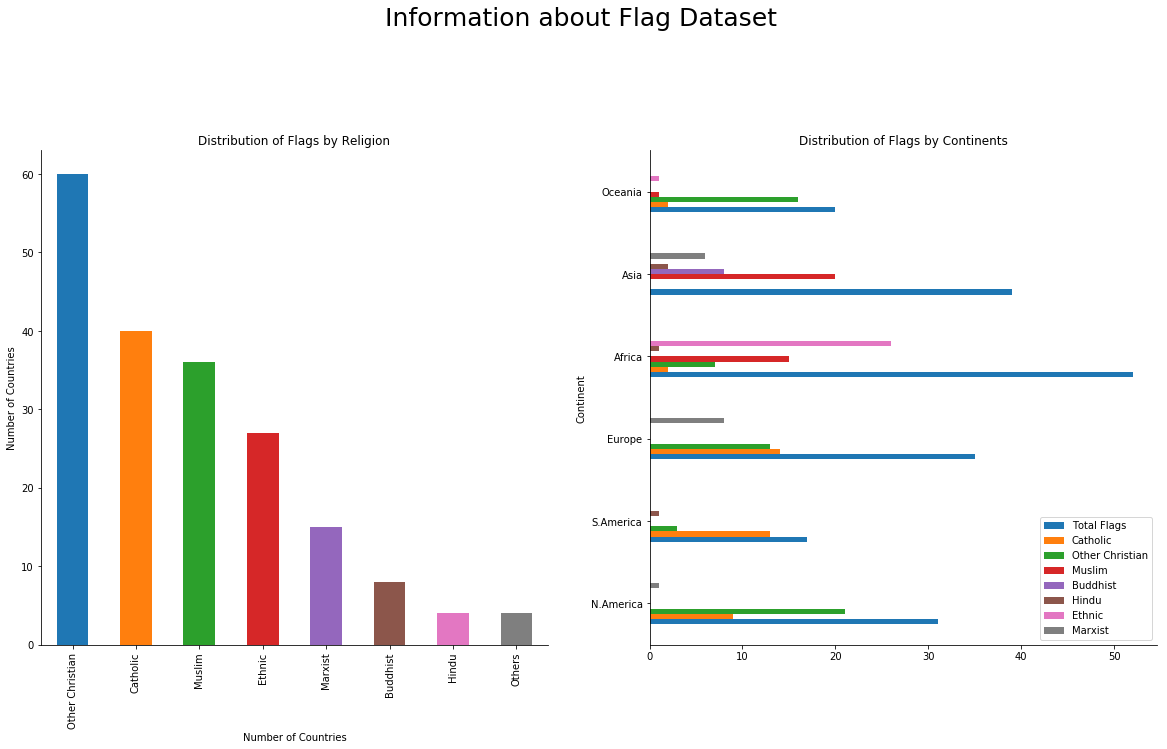

In [311]:

fig = plt.figure(figsize=(20,20))  
g = gs.GridSpec(2,2)
ax = plt.subplot(g[0,0])
ax2 = plt.subplot(g[0,1])

fig.suptitle("Information about Flag Dataset", size= 25)

ax2.set_title("Distribution of Flags by Continents")


country_df.plot(kind="barh",ax=ax2 , legend=True)
ax2.legend(loc='upper left')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.legend(loc=4)
ax.set_xlabel("Number of Countries")

religions.plot(kind="bar", ax = ax)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Number of Countries")
ax.set_title("Distribution of Flags by Religion")


From the data, we can see that there is quite a high bias towards Christian flags. The charts also show that the other dominant flags are Christian,Catholic and Muslim. However, interestingly the Ethnic flags have a high bias in African countries. Due to the high bias, it could potential indicate an identifiable pattern that could be found among the flags despite the low amount of data collected.  

Further feature exploration will be conducted to see the correlation between the features and each religion.

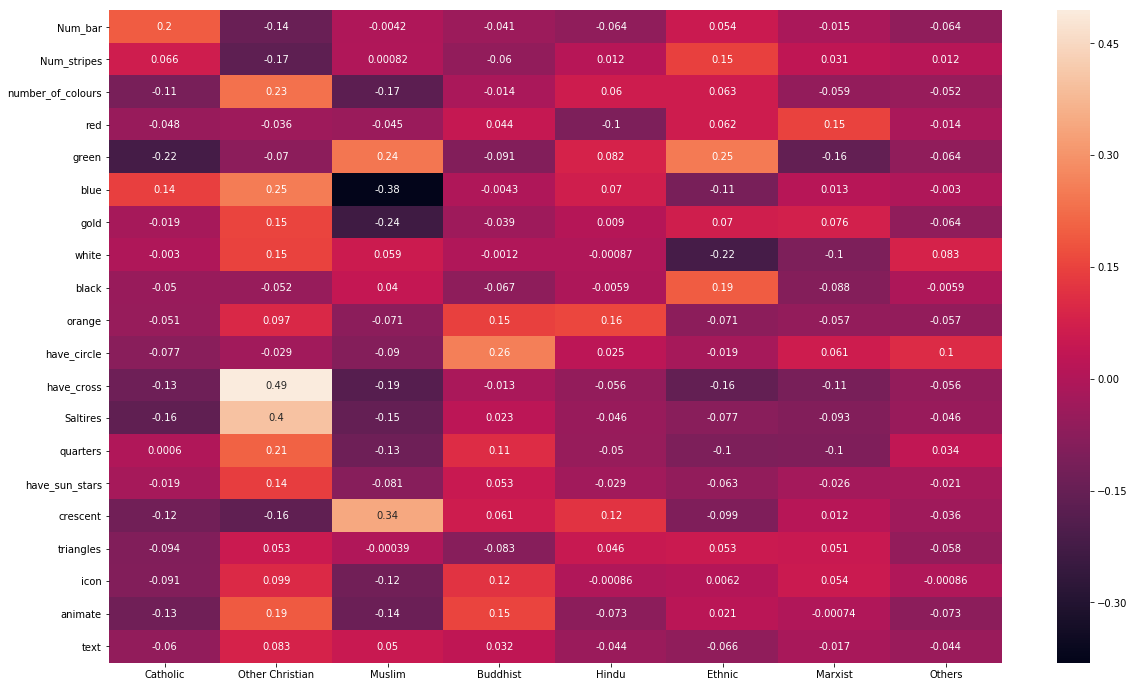

In [312]:
corr_df = df
corr_df = corr_df.reset_index()
extra_columns = pd.get_dummies(corr_df["religion"])
extra_columns = extra_columns.reset_index()
extra_columns = extra_columns.rename(columns ={ 0:"Catholic", 1:"Other Christian", 2:"Muslim", 3:"Buddhist", 4:"Hindu",
               5:"Ethnic", 6:"Marxist", 7:"Others"})
corr_df = pd.merge(corr_df,extra_columns,on="index",how="inner")

corr_df = corr_df.drop(["index","religion","Continent"], 1)
extra_columns = extra_columns.drop("index", 1)
Var_Corr = corr_df.corr().filter(extra_columns).drop(extra_columns)

# plot the heatmap and annotation on it
fig = plt.figure(figsize=(20,12))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.index, annot=True)

In [277]:
df["religion"] = df['religion'].apply(lambda x : x if x < 4 or x == 5 else 7)

From the data, we can that certain features correlate with certain religion more than others. 

1) Catholic : number of bars

2) Christian  : Crosses, Saltires, quarters 

3) Muslim : Crescents, Green

4) Buddhist : Circles, Orange 

5) Ethnic : Green

However, due to the limited data and therefore no recognisable patterns with flags belonging to Marxist, Hindu or others, a decision was made to combine the Marxist and Hindu flags into the others category. We will then examine the data to  see the identified patterns that been discoved by the exploration while also further investigating the new 'other' section to see if a pattern can be found within it. 

In [313]:
religion_dic = { 0:"Catholic", 1:"Other Christian", 2:"Muslim", 3:"Buddhist", 4:"Hindu",
               5:"Ethnic", 6:"Marxist", 7:"Others"}
number_of_bars = df
number_of_bars["religion"] = number_of_bars["religion"].map(religion_dic)
number_of_bars = number_of_bars.groupby(["religion","Num_bar"])["Continent"].agg("count")


print(number_of_bars)

religion         Num_bar
Buddhist         0           7
                 2           1
Catholic         0          27
                 1           1
                 2           3
                 3           9
Ethnic           0          20
                 1           2
                 2           1
                 3           4
Hindu            0           4
Marxist          0          13
                 3           2
Muslim           0          29
                 1           2
                 2           1
                 3           4
Other Christian  0          55
                 1           1
                 2           1
                 3           2
                 5           1
Others           0           4
Name: Continent, dtype: int64


From the table above, we can that the number of bars does offer us some value in our prediction model. However, the number of bars on the flag could correlate more with its continent than its religion. As a lot of Catholic countries are in Europe and there are a lot of European flags that have 3 bars. This could be problematic as there is a high number of Catholic countries in South America, which may not have the same historic flag design as European countries. 




In [314]:
df_s_America = df[["Continent","Num_bar","religion"]]
df_s_America = df_s_America[df_s_America["Continent"] == 2 ]

df_s_America = df_s_America.groupby(["religion","Num_bar"])["Continent"].agg("count")

print(df_s_America)

religion         Num_bar
Catholic         0          11
                 3           2
Hindu            0           1
Other Christian  0           3
Name: Continent, dtype: int64


From the data above, we can see that the Number of Bar has a higher correlation with the Continent than the religion, as the majority of Cathloic countries in South America do not use bars on their flag.

The next step was to examine the correlation between the features and the religion again with the newly added section.

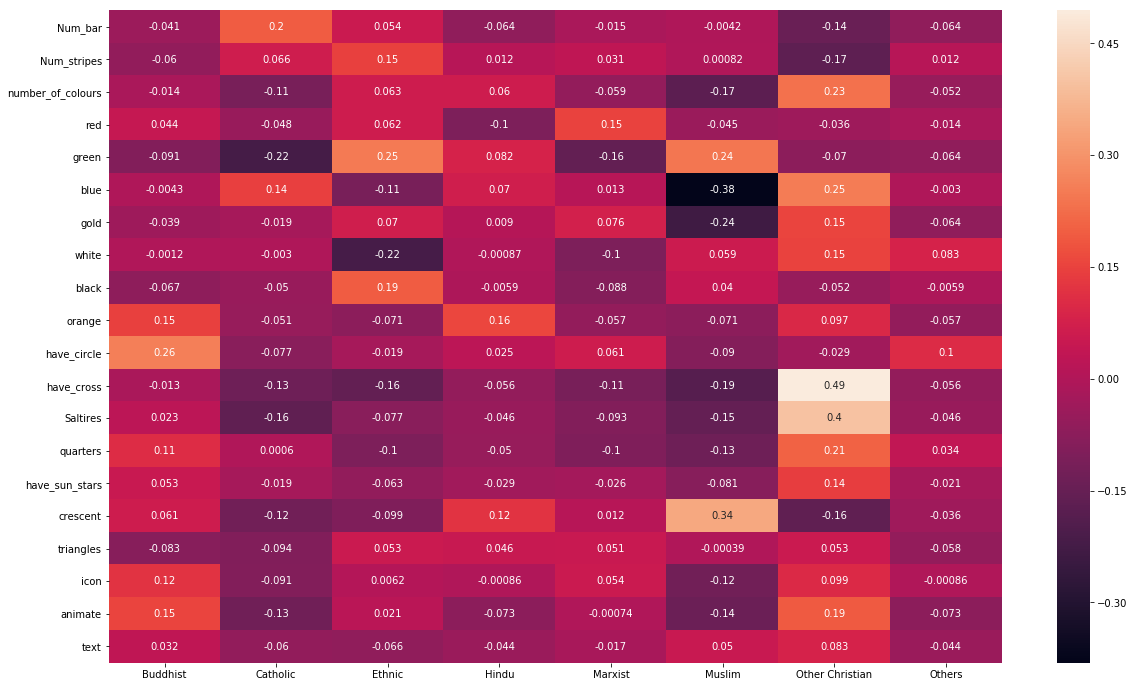

In [315]:
corr_df = df
corr_df = corr_df.reset_index()
extra_columns = pd.get_dummies(corr_df["religion"])
extra_columns = extra_columns.reset_index()
extra_columns = extra_columns.rename(columns ={ 0:"Catholic", 1:"Other Christian", 2:"Muslim", 3:"Buddhist", 4:"Hindu",
               5:"Ethnic", 6:"Marxist", 7:"Others"})
corr_df = pd.merge(corr_df,extra_columns,on="index",how="inner")

corr_df = corr_df.drop(["index","religion","Continent"], 1)
extra_columns = extra_columns.drop("index", 1)
Var_Corr = corr_df.corr().filter(extra_columns).drop(extra_columns)

# plot the heatmap and annotation on it
fig = plt.figure(figsize=(20,12))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.index, annot=True)

The next stage for the data is to explore the results of the data in a model and examine whether other changes can be made to the data. 

<h1> Normalising the Data </h1>

In [316]:
normal_colour_column = pd.get_dummies(df[["mainhue","topleft","botright"]])
df = df.reset_index()
normal_colour_column =normal_colour_column.reset_index()
df = pd.merge(df,normal_colour_column,on="index",how="inner")
df = df.drop(["index","mainhue","topleft","botright"],1)

<h1> Exploring the Algorithms </h1>

A range of algorithms were selected to be fitted with our data.

In [317]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

Text(4.5, 0.5714285714285714, 'Baseline Acc')

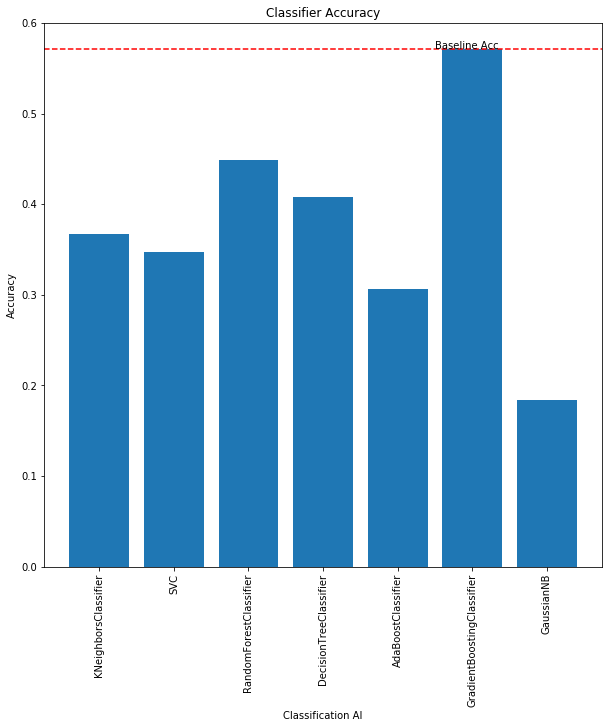

In [318]:

y = df["religion"]
new_x = df.drop(["Continent" , "religion"], 1)
X_train,X_test, y_train,y_test = train_test_split(new_x,y)

classifiers = [
    KNeighborsClassifier(100),
    SVC(kernel="rbf", C=0.025, probability=True,gamma="auto"),
    RandomForestClassifier(100),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()]

# Logging for Visual Comparison

class_al =[]
acc1 = []
confusion_matrix_list = []
labels = y.unique()

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    class_al.append(name)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    acc1.append(acc)
    matrix = confusion_matrix(y_test, train_predictions,labels=labels)

    confusion_matrix_list.append(matrix)
    
max_acc = max(acc1) 
fig, ax = plt.subplots(figsize=(10,10))    
ax.bar(class_al,acc1)
ax.set_xlabel('Classification Al')
ax.set_ylabel('Accuracy')
ax.set_title('Classifier Accuracy')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
ax.axhline(y = max_acc,color = "red",linestyle="--")
ax.annotate("Baseline Acc", xy=(4.5,max_acc))


From the graph above, we can see the best performing algorithm. The results of the algorithm was then examined to see if changes could be made to the data.

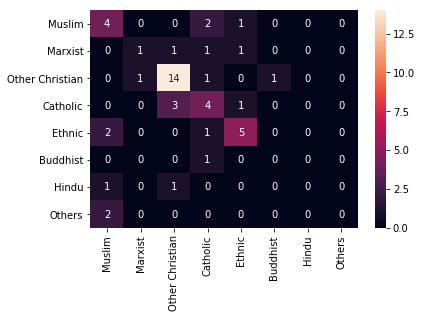

In [322]:
best_al = acc1.index(max_acc)
df_cm = pd.DataFrame(confusion_matrix_list[best_al], range(8),
                  range(8))
sns.heatmap(df_cm, annot=True,xticklabels=labels, yticklabels=labels)


From the confusion martix, we can see that a number of issues with the model including :

1)the Buddhist's flags are being place in mulitple incorrect categories.

2) The Ethnic and Muslim Flags are being wrongly classified together. 

3) The other Flags is being wrongly classified with the Muslim flags.

To try and create a more accurate model, I will add the Ethnic and Buddhist's flags into the other section.

In [323]:
df["religion"] = df["religion"].apply(lambda x : x if x == "Muslim" or x == "Other Christian" or x == "Catholic" else "Others")

Text(4.5, 0.5102040816326531, 'Baseline Acc')

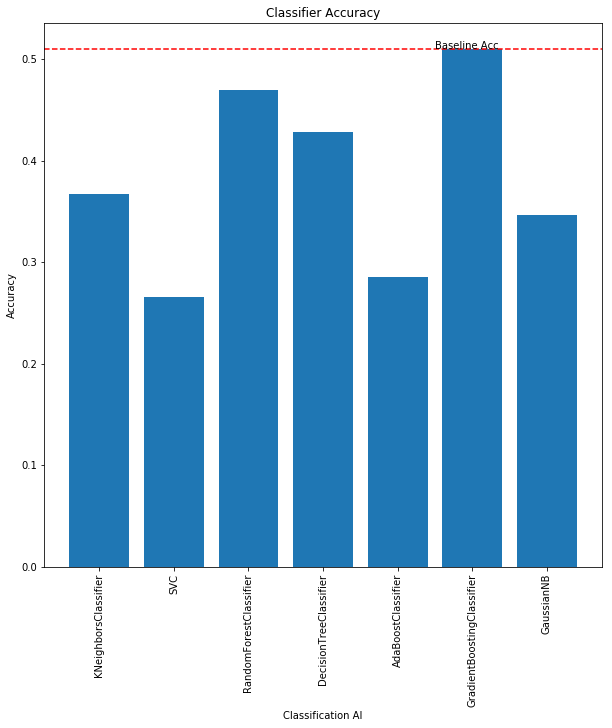

In [324]:

y = df["religion"]
new_x = df.drop(["Continent" , "religion"], 1)
X_train,X_test, y_train,y_test = train_test_split(new_x,y)

classifiers = [
    KNeighborsClassifier(100),
    SVC(kernel="rbf", C=0.025, probability=True,gamma="auto"),
    RandomForestClassifier(100),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB()]

# Logging for Visual Comparison

class_al =[]
acc1 = []
confusion_matrix_list = []
labels = y.unique()

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    class_al.append(name)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    acc1.append(acc)
    matrix = confusion_matrix(y_test, train_predictions,labels=labels)

    confusion_matrix_list.append(matrix)
    
max_acc = max(acc1) 
fig, ax = plt.subplots(figsize=(10,10))    
ax.bar(class_al,acc1)
ax.set_xlabel('Classification Al')
ax.set_ylabel('Accuracy')
ax.set_title('Classifier Accuracy')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
ax.axhline(y = max_acc,color = "red",linestyle="--")
ax.annotate("Baseline Acc", xy=(4.5,max_acc))


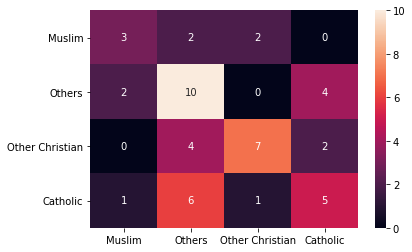

In [325]:
best_al = acc1.index(max_acc)
df_cm = pd.DataFrame(confusion_matrix_list[best_al], range(4),
                  range(4))
sns.heatmap(df_cm, annot=True,xticklabels=labels, yticklabels=labels)

From the graph above, we can see that the simplfication of the data has not made the model more effective, as the increase other category is now making False Negatives in both the Christian and Catholic groups.  

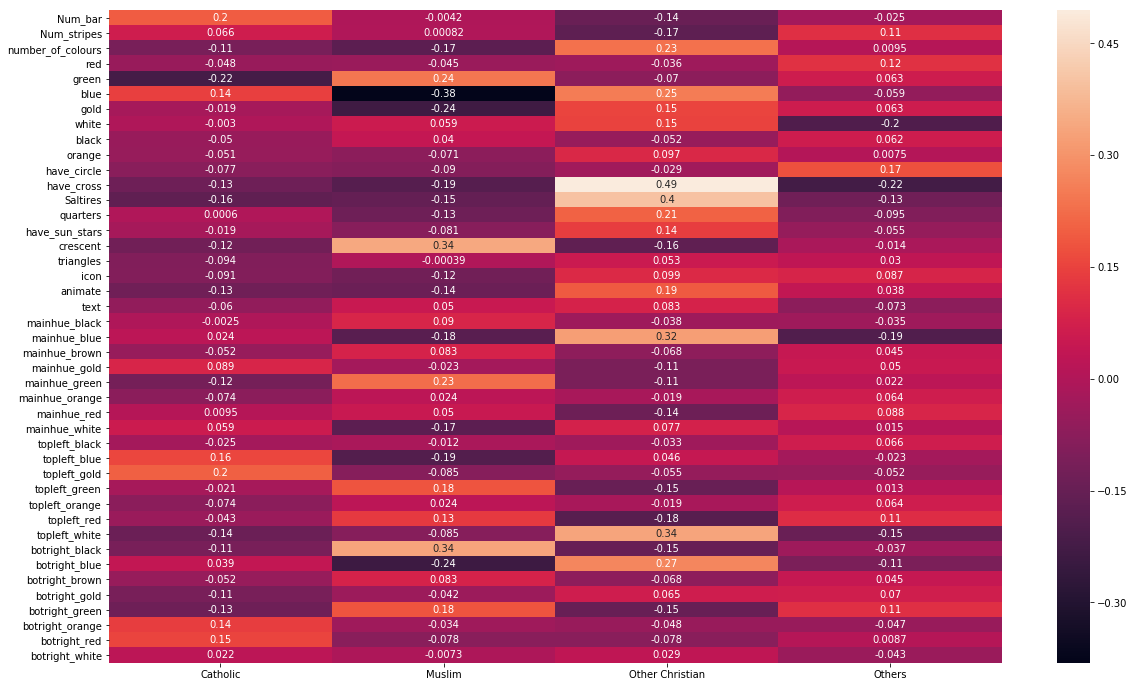

In [326]:
corr_df = df
corr_df = corr_df.reset_index()
extra_columns = pd.get_dummies(corr_df["religion"])
extra_columns = extra_columns.reset_index()
extra_columns = extra_columns.rename(columns ={ 0:"Catholic", 1:"Other Christian", 2:"Muslim", 3:"Buddhist", 4:"Hindu",
               5:"Ethnic", 6:"Marxist", 7:"Others"})
corr_df = pd.merge(corr_df,extra_columns,on="index",how="inner")

corr_df = corr_df.drop(["index","religion","Continent"], 1)
extra_columns = extra_columns.drop("index", 1)
Var_Corr = corr_df.corr().filter(extra_columns).drop(extra_columns)

# plot the heatmap and annotation on it
fig = plt.figure(figsize=(20,12))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.index, annot=True)

After experimenting with reducing the amount of variable that have a high correlatation between the sections :  Others and Christians / Others and Catholic, the model was unable to be improved.   

<h1> Optimising the Model </h1>

The next stage is to improve the model by tuning the parameters so it matches the data better.

In [331]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 40, num = 4)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [20, 50,100,150]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               }
   

In [332]:
from sklearn.model_selection import RandomizedSearchCV
rf = GradientBoostingClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(new_x,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished
C:\Users\NJGaj\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [4, 16, 28, 40, None], 'min_samples_leaf': [20, 50, 100, 150]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [333]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_leaf': 20,
 'max_features': 'sqrt',
 'max_depth': 28}

In [336]:
from sklearn.model_selection import cross_val_score
clf = GradientBoostingClassifier(n_estimators = 600,
 min_samples_leaf = 20,
 max_features ="sqrt",
 max_depth = 28) 

forest_cross_val = np.mean(cross_val_score(clf, new_x,y, cv=10))

In [337]:
print("The New acc Rating for Random Forest Model is :  ")
print("{:.2f}".format(forest_cross_val))

The New acc Rating for Random Forest Model is :  
0.45


<h1> Evaluating the model </h1>


It is quite clear to see that without extra data, no effective model can be produced to meet the aims of the project. The potential routes that we can take are:

1) Get a greater sample size

2) Reduce the categories and features to a point whether there are more obvious identifiers.